In [ ]:
# python 3.10.12
# !pip install -r requirements.txt

In [ ]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.style as style
import seaborn as sns
style.use("fivethirtyeight")
import folium
from folium.plugins import MarkerCluster
from matplotlib.colors import to_hex
from matplotlib import cm

from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, roc_curve, auc,
                             recall_score, accuracy_score)

# 1. Introdução

Este notebook faz parte de um projeto mais amplo cujo objetivo é analisar dados de avaliações e estabelecimentos da plataforma Yelp, com foco na identificação de padrões de comportamento dos consumidores, fatores associados à percepção de qualidade e níveis de engajamento dos usuários.

Neste módulo específico, o foco está na Análise de Sentimento das avaliações textuais, por meio de técnicas de classificação supervisionada, com o objetivo de extrair insights a partir do conteúdo textual gerado pelos utilizadores. Esse tipo de abordagem é amplamente utilizado em contextos de negócio — inclusive pela própria Yelp — para sintetizar grandes volumes de feedback, apoiar o monitoramento da experiência do cliente e subsidiar decisões estratégicas de forma escalável.

A análise considera o texto das avaliações como principal fonte de informação, relacionando-o à nota atribuída (stars) para a construção de um modelo capaz de classificar automaticamente o sentimento expresso pelos usuários.

## Objetivos da Análise de Sentimento

As análises conduzidas neste notebook têm como objetivos principais:

- Construir uma variável alvo de sentimento com base na avaliação atribuída pelos usuários;

- Analisar a distribuição das classes e avaliar possíveis desequilíbrios;

- Preparar e transformar os textos das avaliações para modelagem supervisionada;

- Treinar e avaliar modelos de classificação de sentimento;

- Investigar quais termos e padrões textuais estão mais associados a avaliações positivas e negativas;

- Gerar insights que possam apoiar estratégias de monitoramento da experiência do cliente, reputação e engajamento.

Além de avaliar o desempenho global dos modelos, a análise prioriza métricas sensíveis ao desbalanceamento de classes, com ênfase especial no **recall da classe negativa**, dado o impacto crítico que avaliações negativas têm na identificação de problemas operacionais, na detecção precoce de insatisfação dos usuários e na gestão da reputação dos negócios. Nesse contexto, minimizar falsos negativos — isto é, avaliações negativas classificadas incorretamente como positivas — é considerado mais relevante do que maximizar exclusivamente métricas globais como acurácia.

Os resultados obtidos neste módulo complementam as análises exploratórias, inferenciais e de segmentação realizadas nos notebooks anteriores, ampliando a compreensão do comportamento dos consumidores a partir de uma perspectiva textual e semântica.

## Organização do Projeto

O projeto está estruturado de forma modular, com notebooks e componentes que podem ser analisados de maneira independente, garantindo reprodutibilidade e clareza na apresentação dos resultados.

Além deste notebook, o projeto inclui os seguintes módulos:

- **Análise de Clusters**: segmentação dos estabelecimentos com base em métricas de avaliação e engajamento;
- **Classificação Supervisionada**: análise de sentimento das avaliações textuais por meio de modelos de machine learning;
- **Dashboard Interativo**: visualização dos principais insights para apoio à tomada de decisão.

A preparação e limpeza dos dados utilizados nas análises foram realizadas no notebook "EDA_inferencial.ipynb".

# 2. Preparação dos Dados

Foi criada uma nova variável alvo denominada sentiment, que classifica as avaliações como positivas (1) ou negativas (0) com base na nota atribuída, adotando o limiar de stars ≥ 3.5, previamente validado na etapa de análise inferencial.

Antes da modelagem, foi realizada uma análise exploratória da variável alvo com o objetivo de avaliar sua distribuição e identificar possíveis desequilíbrios entre as classes, garantindo maior robustez nas etapas subsequentes de treinamento e avaliação dos modelos (Conferir o notebook "EDA_inferencial.ipynb".)


## Pré-processamento de Texto

O texto das avaliações foi transformado em representação numérica por meio do TF-IDF (Term Frequency–Inverse Document Frequency), capturando tanto a frequência quanto a relevância das palavras no corpus. Além disso, foi aplicado o teste qui-quadrado para seleção das palavras mais informativas para a tarefa de classificação, contribuindo para a redução de dimensionalidade e melhoria do desempenho dos modelos.

In [ ]:
df_review = pd.read_json('df_review_tennessee_cleaned.json', lines=True)
df_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614388 entries, 0 to 614387
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   review_id     614388 non-null  object        
 1   user_id       614388 non-null  object        
 2   business_id   614388 non-null  object        
 3   stars         614388 non-null  int64         
 4   useful        614388 non-null  int64         
 5   funny         614388 non-null  int64         
 6   cool          614388 non-null  int64         
 7   text          614388 non-null  object        
 8   date          614388 non-null  datetime64[ns]
 9   weekday       614388 non-null  int64         
 10  is_weekend    614388 non-null  bool          
 11  month         614388 non-null  int64         
 12  year          614388 non-null  int64         
 13  hour          614388 non-null  int64         
 14  time_of_day   614388 non-null  object        
 15  cleaned_text  614

## Definição do limiar para classificação binária

O limiar de 3,5 estrelas foi adotado para a construção da variável alvo de sentimento, classificando avaliações como positivas (stars ≥ 3,5) ou negativas (stars < 3,5).

A escolha desse threshold foi previamente validada na etapa de Análise Exploratória e Inferencial, onde verificou-se que os grupos definidos por esse critério apresentam separação estatisticamente significativa, com intervalos de confiança não sobrepostos (Conferir o notebook "EDA_inferencial.ipynb".).

Do ponto de vista de negócio, esse limiar contribui para reduzir ambiguidades semânticas entre avaliações neutras e extremas, além de reforçar a distinção entre experiências claramente positivas e negativas. Essa definição é particularmente relevante neste projeto, uma vez que a prioridade analítica está na identificação consistente de avaliações negativas, minimizando falsos negativos e apoiando ações de monitoramento da reputação e detecção de problemas operacionais.

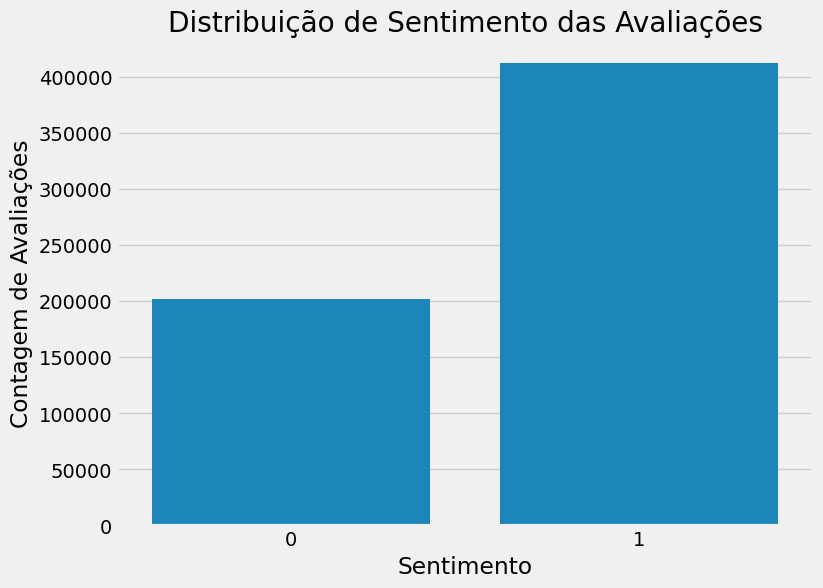

In [ ]:
df_review['sentiment'] = (df_review['stars'] >= 3.5).astype(int)
df_review['sentiment'].value_counts()

# Gráfico de barras para 'sentiment'
plt.figure(figsize=(8, 6))
sns.countplot(data=df_review, x='sentiment')
plt.title('Distribuição de Sentimento das Avaliações')
plt.xlabel('Sentimento')
plt.ylabel('Contagem de Avaliações')
plt.show()

In [ ]:
df_review.to_parquet("df_review_target.parquet")

## Balanceamento da Variável Alvo

A variável alvo apresentou desbalanceamento significativo, com predominância da classe positiva (412.440 observações) em relação à classe negativa (201.948 observações). Esse cenário pode introduzir viés nos modelos de classificação, favorecendo a classe majoritária e prejudicando o desempenho na identificação de avaliações negativas.

Para mitigar esse efeito, foram adotadas as seguintes estratégias:

- Utilização do parâmetro stratify na divisão entre conjuntos de treino e teste, preservando a proporção das classes;

- Aplicação do parâmetro class_weight='balanced' ou 'scale_pos_weight' nos modelos supervisionados, ajustando o peso das classes de forma inversamente proporcional à sua frequência.

Essas abordagens visam melhorar a capacidade de generalização dos modelos e aumentar a sensibilidade à classe minoritária.

# 3. Modelagem

## 3.1 Baseline

In [ ]:
# Definir as colunas de entrada
features = ['cleaned_text', 'useful', 'funny', 'cool', 'is_weekend', 'year', 'time_of_day']
target = 'sentiment'

# Separar os dados em treino, teste e validação
X = df_review[features]
y = df_review[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [ ]:
# Aplicar TfidfVectorizer ao texto
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X_train['cleaned_text'])

# Obter os nomes das features geradas
feature_names = tfidf_vectorizer.get_feature_names_out()

# Calcular o qui quadrado
chi_values, p_values = chi2(X_tfidf, y_train)

# Combinar as features com seus valores \( \chi^2 \) e \( p \)-valores
zipped_results = zip(feature_names, chi_values, p_values)

# Ordenar as features pelo valor \( \chi^2 \) em ordem decrescente
sorted_results = sorted(zipped_results, key=lambda x: x[1], reverse=True)

# Exibir as 10 palavras mais importantes com seus valores \( \chi^2 \) e \( p \)
for word, chi, p in sorted_results[:20]:
    print(f"Feature: {word}, Chi^2: {chi:.2f}, p-value: {p:.5f}")

Feature: great, Chi^2: 2534.46, p-value: 0.00000
Feature: rude, Chi^2: 2397.35, p-value: 0.00000
Feature: worst, Chi^2: 2305.93, p-value: 0.00000
Feature: terribl, Chi^2: 1990.59, p-value: 0.00000
Feature: told, Chi^2: 1893.23, p-value: 0.00000
Feature: amaz, Chi^2: 1851.05, p-value: 0.00000
Feature: horribl, Chi^2: 1829.79, p-value: 0.00000
Feature: delici, Chi^2: 1690.39, p-value: 0.00000
Feature: love, Chi^2: 1531.75, p-value: 0.00000
Feature: said, Chi^2: 1515.19, p-value: 0.00000
Feature: minut, Chi^2: 1353.81, p-value: 0.00000
Feature: poor, Chi^2: 1337.88, p-value: 0.00000
Feature: ask, Chi^2: 1335.08, p-value: 0.00000
Feature: manag, Chi^2: 1322.00, p-value: 0.00000
Feature: call, Chi^2: 1250.77, p-value: 0.00000
Feature: ok, Chi^2: 1221.04, p-value: 0.00000
Feature: best, Chi^2: 1196.59, p-value: 0.00000
Feature: money, Chi^2: 1148.16, p-value: 0.00000
Feature: awesom, Chi^2: 1078.49, p-value: 0.00000
Feature: perfect, Chi^2: 1073.93, p-value: 0.00000


## Seleção de Features com Qui-Quadrado

A técnica de teste Qui-Quadrado foi utilizada para identificar as palavras mais relevantes na distinção entre avaliações positivas e negativas. Os resultados indicaram que termos como “great”, “amazing”, “perfect” e “delicious” estão fortemente associados a avaliações positivas, enquanto palavras como “rude”, “worst”, “terrible”, “poor” e “bad” aparecem com maior frequência em avaliações negativas.

Todas as palavras selecionadas apresentaram p-valores extremamente baixos (≈ 0.000), indicando alta significância estatística e forte poder discriminativo. Essa análise contribuiu não apenas para a melhoria do desempenho do modelo, mas também para a interpretabilidade, permitindo compreender quais termos influenciam diretamente a classificação do sentimento.

A aplicação do SelectKBest com base no Qui-Quadrado permitiu reduzir a dimensionalidade do espaço de features, removendo termos pouco informativos e tornando os modelos mais eficientes sem perda relevante de desempenho.

## Criação de Pipelines

Foram construídos pipelines independentes para o processamento de diferentes tipos de variáveis, garantindo modularidade, reprodutibilidade e clareza na etapa de modelagem:

- Texto: vetorização com CountVectorizer e TfidfTransformer, seguida de seleção de características com SelectKBest;

- Dados numéricos: padronização utilizando StandardScaler;

- Dados categóricos: codificação com OneHotEncoder.

In [ ]:
# Pipeline para o texto (CountVectorizer, TfidfTransformer e SelectKBest)
text_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=100)),
    ('tfidf', TfidfTransformer()),
    ('feature_selection', SelectKBest(chi2, k=10))  # Selecionar as 10 melhores features
])

# Pipeline para colunas numéricas
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Pipeline para colunas categóricas
categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Aplicar as transformações por coluna
preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'cleaned_text'),
    ('num', numeric_pipeline, ['useful', 'funny', 'cool', 'year']),
    ('cat', categorical_pipeline, ['is_weekend', 'time_of_day'])
])

**Observação técnica:**
Para otimizar o tempo de execução e a complexidade computacional do baseline, foram adotadas algumas restrições práticas, como:

- Limitação do número máximo de features no CountVectorizer (100);

- Seleção das 10 melhores features textuais;

- Redução do número de estimadores no Random Forest (20).

Essas decisões não comprometem a validade metodológica da análise e são comuns em ambientes exploratórios e demonstrativos.

## Modelagem e Avaliação

Foram avaliados três algoritmos de classificação supervisionada:

- Regressão Logística

- XGBoost

- Random Forest

O desempenho dos modelos foi comparado com base na métrica principal (recall negativo) e outros resultados, incluindo:

- Acurácia: proporção total de previsões corretas;

- Matriz de Confusão: análise detalhada de verdadeiros e falsos positivos/negativos;

- Relatório de Classificação: métricas de precisão, recall e F1-score;

- AUC-ROC: capacidade do modelo em distinguir corretamente entre avaliações positivas e negativas.

In [ ]:
def evaluate_model(y_true, y_pred, y_proba, label=None, k=None):
    report = classification_report(
        y_true,
        y_pred,
        target_names=["Negative", "Positive"],
        output_dict=True
    )

    results = {
        "label": label,
        "k": k,
        "accuracy": accuracy_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba),
        "recall_negative": report["Negative"]["recall"],
        "recall_positive": report["Positive"]["recall"],
        "confusion_matrix": confusion_matrix(y_true, y_pred),
    }

    return results

In [ ]:
def plot_confusion_matrix(cm, title="", class_names=("Negative", "Positive")):
    cm = np.array(cm)

    if cm.shape != (2, 2):
        raise ValueError("Confusion matrix deve ser 2x2")

    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(
                j, i, cm[i, j],
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black"
            )

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

In [ ]:
# Modelos a serem usados
baseline_results = {}
models = {
    'Logistic Regression': LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ),
    'XGBoost': XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        eval_metric='logloss',
        random_state=42
    ),
    'Random Forest': RandomForestClassifier(
        class_weight='balanced',
        n_estimators=50,
        random_state=42
    )
}


# Treinar e avaliar os modelos
results = {}

for model_name, model in models.items():
    # Criar o pipeline completo
    clf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Treinar o modelo
    clf_pipeline.fit(X_train, y_train)

    # Prever no conjunto de validação
    y_pred = clf_pipeline.predict(X_val)
    y_proba = clf_pipeline.predict_proba(X_val)[:, 1] if hasattr(clf_pipeline, 'predict_proba') else None

    baseline_results[model_name] = evaluate_model(y_val,
                                                  y_pred,
                                                  y_proba,
                                                  label=model_name
                                                  )
    df_baseline = pd.DataFrame(baseline_results.values())

## Visualização dos Resultados

Além da tabela com as métricas principais de cada modelo, foram geradas matrizes de confusão para avaliação, facilitando a análise crítica e a seleção do modelo mais adequado.

In [ ]:
df_baseline

,label,k,accuracy,roc_auc,recall_negative,recall_positive,confusion_matrix
0,Logistic Regression,None,0.744633,0.836491,0.811226,0.711921,"[[32836, 7641], [23738, 58663]]"
1,XGBoost,None,0.754911,0.844738,0.802431,0.731569,"[[32480, 7997], [22119, 60282]]"
2,Random Forest,None,0.738912,0.808911,0.719174,0.748607,"[[29110, 11367], [20715, 61686]]"


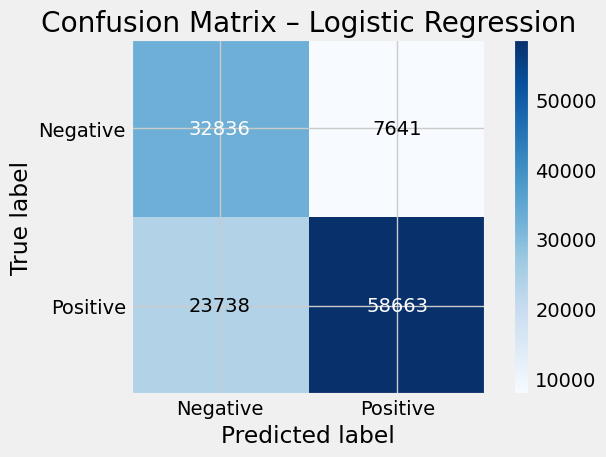

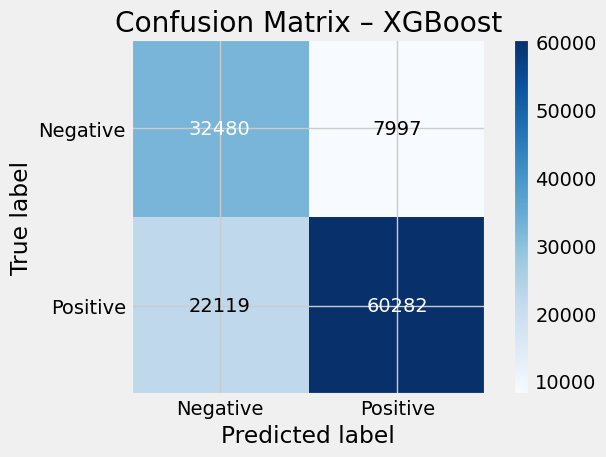

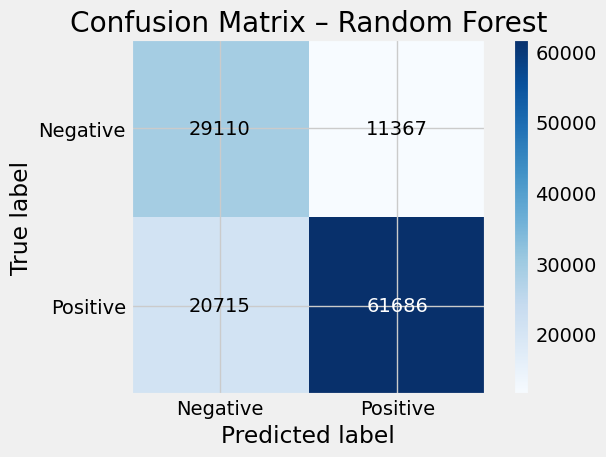

In [ ]:
for _, row in df_baseline.iterrows():
    plot_confusion_matrix(
        row["confusion_matrix"],
        title=f"Confusion Matrix – {row['label']}"
    )

### Avaliação dos Modelos – Baseline

Foram avaliados três modelos para classificação de sentimento: Regressão Logística, Random Forest e XGBoost, considerando desbalanceamento das classes e com ênfase na identificação de avaliações negativas.

Métricas principais

- Recall da classe negativa (métrica prioritária)

- AUC-ROC (capacidade de separação entre classes)

- Acurácia (métrica complementar)


**Regressão Logística**

- Acurácia: 74,46%

- Recall (Negativo): 0,81

- Recall (Positivo): 0,71

- AUC-ROC: 0,836

A Regressão Logística apresentou alto recall para a classe negativa, sendo eficiente na identificação de avaliações negativas. No entanto, esse ganho ocorre com perda moderada de recall na classe positiva, indicando um trade-off entre as classes.

**XGBoost**

- Acurácia: 75,49%

- Recall (Negativo): 0,80

- Recall (Positivo): 0,73

- AUC-ROC: 0,845

O XGBoost apresentou o melhor desempenho geral, combinando alto recall para avaliações negativas com o maior AUC-ROC entre os modelos. Esse resultado indica melhor capacidade de separação entre classes e maior robustez frente ao desbalanceamento dos dados.

**Random Forest**

- Acurácia: 73,89%

- Recall (Negativo): 0,72

- Recall (Positivo): 0,75

- AUC-ROC: 0,809

O Random Forest apresentou desempenho mais equilibrado entre as classes, porém com menor sensibilidade à classe negativa quando comparado aos demais modelos, além de menor capacidade discriminativa global.

**Conclusão do Baseline**

Entre os modelos avaliados, o XGBoost foi selecionado como baseline final, por apresentar o melhor equilíbrio entre recall da classe negativa e AUC-ROC, métricas prioritárias para o objetivo do projeto: detectar avaliações negativas com maior sensibilidade.

## 3.2 Modelagem XGBoost

Nesta seção, é apresentada uma segunda rodada de treinamentos, agora apenas com o XGBoost (que obteve o melhor desempenho na rodada de baseline) e testando diferentes valores de k (melhores palavras com base no teste qui-quadrado).

In [ ]:
k_values = [50, 100, 200, 300, 400, 500]
results_k = []

for k in k_values:
    print(f"\nTreinando XGBoost com k={k}")

    # Pipeline de texto
    text_pipeline = Pipeline([
        ('vectorizer', CountVectorizer(max_features=k)),
        ('tfidf', TfidfTransformer()),
        ('feature_selection', SelectKBest(chi2, k=k))
    ])

    # Numéricas
    numeric_pipeline = Pipeline([
        ('scaler', StandardScaler())
    ])

    # Categóricas
    categorical_pipeline = Pipeline([
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
    ])

    # Preprocessor
    preprocessor = ColumnTransformer([
        ('text', text_pipeline, 'cleaned_text'),
        ('num', numeric_pipeline, ['useful', 'funny', 'cool', 'year']),
        ('cat', categorical_pipeline, ['is_weekend', 'time_of_day'])
    ])

    # Modelo
    model = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=(y_train.value_counts()[0] / y_train.value_counts()[1]),
        eval_metric='logloss',
        random_state=42
    )

    # Pipeline completo
    clf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Treino
    clf_pipeline.fit(X_train, y_train)

    # Previsões
    y_pred = clf_pipeline.predict(X_val)
    y_proba = clf_pipeline.predict_proba(X_val)[:, 1]

    results_k.append(
    evaluate_model(
        y_val,
        y_pred,
        y_proba,
        label="XGBoost",
        k=k
        )
    )

# Resultados finais
df_results_k = pd.DataFrame(results_k)


Treinando XGBoost com k=50

Treinando XGBoost com k=100

Treinando XGBoost com k=200

Treinando XGBoost com k=300

Treinando XGBoost com k=400

Treinando XGBoost com k=500


In [ ]:
df_results_k

,label,k,accuracy,roc_auc,recall_negative,recall_positive,confusion_matrix
0,XGBoost,50,0.787163,0.873897,0.796650,0.782503,"[[32246, 8231], [17922, 64479]]"
1,XGBoost,100,0.812033,0.897508,0.820886,0.807684,"[[33227, 7250], [15847, 66554]]"
2,XGBoost,200,0.841534,0.923502,0.849174,0.837781,"[[34372, 6105], [13367, 69034]]"
3,XGBoost,300,0.851210,0.931555,0.856215,0.848752,"[[34657, 5820], [12463, 69938]]"
4,XGBoost,400,0.861122,0.938422,0.862465,0.860463,"[[34910, 5567], [11498, 70903]]"
5,XGBoost,500,0.865517,0.942093,0.865751,0.865402,"[[35043, 5434], [11091, 71310]]"


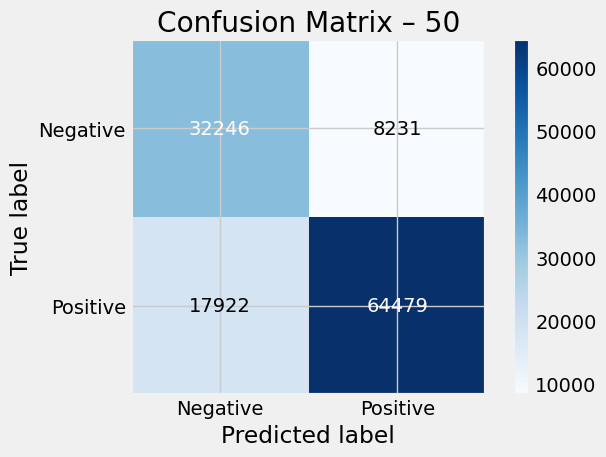

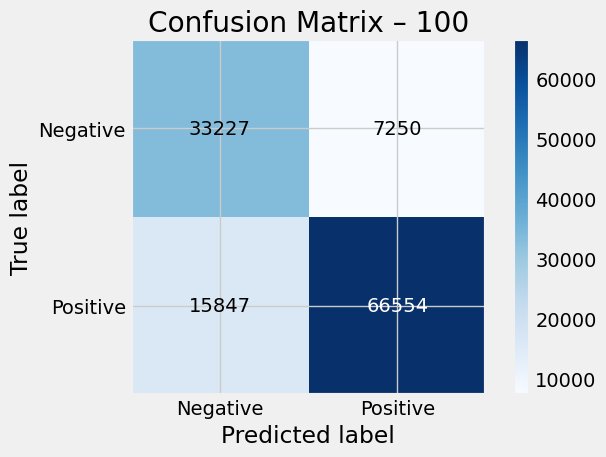

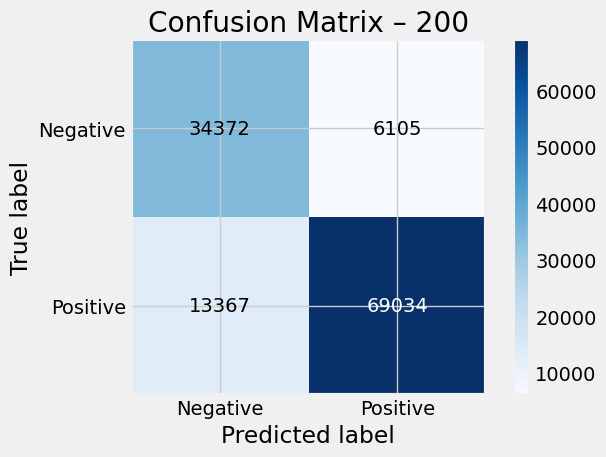

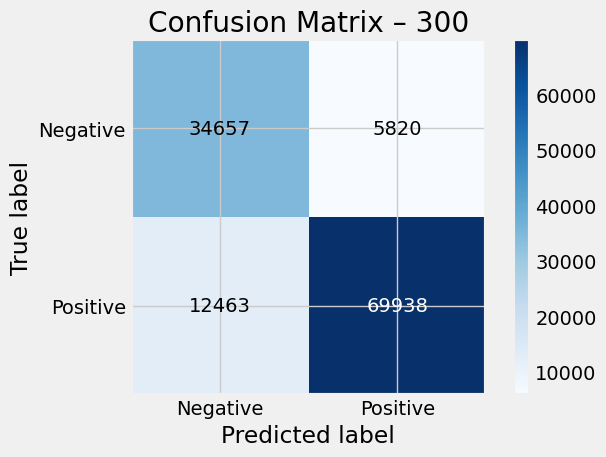

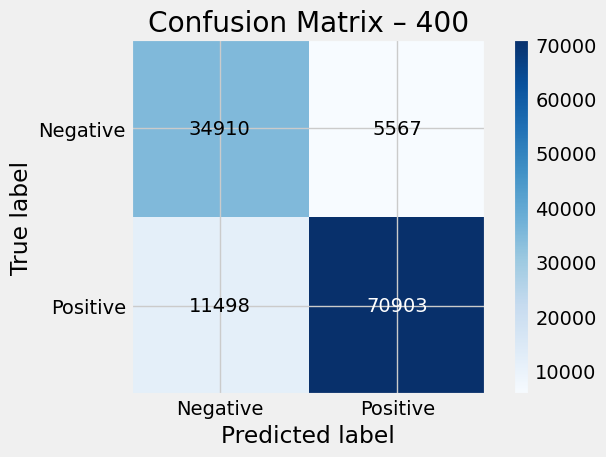

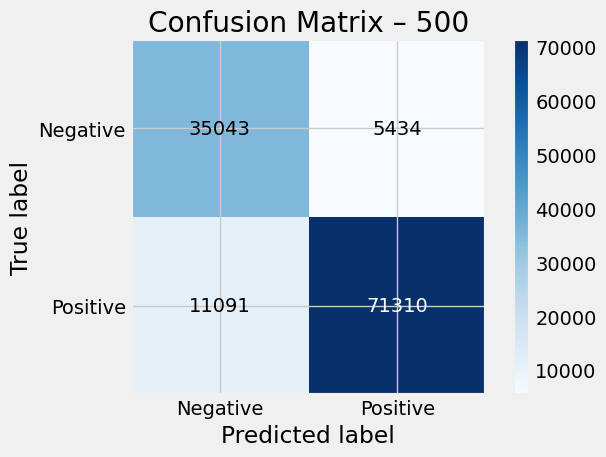

In [ ]:
for _, row in df_results_k.iterrows():
    plot_confusion_matrix(
        row["confusion_matrix"],
        title=f"Confusion Matrix – {row['k']}"
    )

## Avaliação do Impacto do Número de Features (k)

Foi realizada uma análise de sensibilidade variando o número de features textuais selecionadas (k), com valores entre 50 e 500, a fim de avaliar o impacto da dimensionalidade no desempenho do modelo XGBoost. Os resultados completos encontram-se apresentados em tabela/gráfico, permitindo a comparação direta entre as configurações avaliadas.

Observa-se uma melhora progressiva e consistente em todas as métricas à medida que k aumenta, com ganhos mais expressivos até aproximadamente k = 300. A partir desse ponto, os incrementos tornam-se mais marginais, indicando um possível retorno decrescente em relação ao aumento da complexidade do modelo.

O modelo com k = 500 apresentou o melhor desempenho geral, atingindo AUC-ROC de 0,94 e recall de 0,87 para a classe negativa, mantendo excelente equilíbrio entre as classes. Dessa forma, essa configuração foi selecionada como o modelo final, por alinhar melhor desempenho preditivo com o objetivo do projeto: maximizar a sensibilidade à detecção de avaliações negativas.



# 4. Resultados

Nesta seção, o modelo ideal escolhido será testado com os dados separados para teste.

In [ ]:
X_train_final = pd.concat([X_train, X_val])
y_train_final = pd.concat([y_train, y_val])

# Texto
text_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(max_features=500)),
    ('tfidf', TfidfTransformer()),
    ('feature_selection', SelectKBest(chi2, k=500))
])

# Numéricas
numeric_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Categóricas
categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Preprocessador
preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'cleaned_text'),
    ('num', numeric_pipeline, ['useful', 'funny', 'cool', 'year']),
    ('cat', categorical_pipeline, ['is_weekend', 'time_of_day'])
])

model_final = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_train_final.value_counts()[0] / y_train_final.value_counts()[1]),
    eval_metric='logloss',
    random_state=42
)

final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', model_final)
])

final_pipeline.fit(X_train_final, y_train_final)

y_test_pred = final_pipeline.predict(X_test)
y_test_proba = final_pipeline.predict_proba(X_test)[:, 1]

final_test_results = evaluate_model(
    y_test,
    y_test_pred,
    y_test_proba,
    label="Final Model",
    k=500
)

df_test_results = pd.DataFrame([final_test_results])

In [ ]:
df_test_results

,label,k,accuracy,roc_auc,recall_negative,recall_positive,confusion_matrix
0,Final Model,500,0.865558,0.942712,0.869148,0.8638,"[[35104, 5285], [11235, 71254]]"


In [ ]:
# Salvar o dataframe para utilizar no dashboard
df_to_save = df_test_results.copy()

# Converte a coluna de listas para string JSON
df_to_save["confusion_matrix"] = df_to_save["confusion_matrix"].apply(lambda x: json.dumps(x.tolist() if hasattr(x, "tolist") else x))


# Salvar parquet
df_to_save.to_parquet("df_test_results.parquet", index=False)

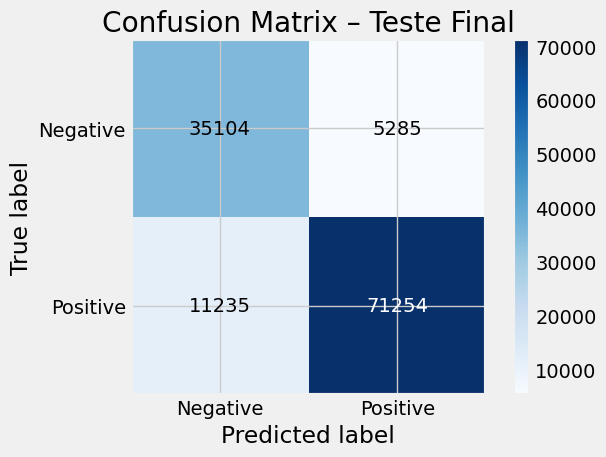

In [ ]:
plot_confusion_matrix(
    df_test_results["confusion_matrix"].iloc[0],
    title="Confusion Matrix – Teste Final"
)


## Avaliação do Modelo Final (k = 500)

O modelo final XGBoost foi treinado utilizando 500 features textuais selecionadas e avaliado no conjunto de teste, considerando todas as métricas principais previamente definidas: Recall da classe negativa (métrica prioritária), AUC-ROC (capacidade de separação entre classes) e Acurácia (métrica complementar).

Resultados principais:

- Acurácia: 86,56%

- AUC-ROC: 0,943

- Recall (classe negativa): 0,869

- Recall (classe positiva): 0,864

A matriz de confusão revelou que o modelo identificou corretamente 35.104 avaliações negativas e 71.254 avaliações positivas, apresentando um número relativamente baixo de falsos negativos (11.235) e falsos positivos (5.285).

O desempenho do modelo indica excelente capacidade de detecção de avaliações negativas, mantendo ao mesmo tempo bom equilíbrio entre as classes. O alto valor de AUC-ROC confirma que o modelo possui ótima capacidade de separação entre avaliações positivas e negativas.

Dessa forma, o modelo final foi selecionado como a configuração definitiva, por alinhar alta sensibilidade à detecção de avaliações negativas com robustez preditiva e equilíbrio geral entre classes.

# 5. Conclusão

## Síntese da Análise

Neste notebook, foi conduzida uma etapa de classificação supervisionada com o objetivo de realizar a análise de sentimento das avaliações textuais da plataforma Yelp. A partir da definição de um threshold de 3,5 estrelas, previamente validado na análise inferencial, as avaliações foram rotuladas como positivas ou negativas, estruturando um problema de classificação binária alinhado ao contexto de negócio.

O pipeline incluiu preparação e transformação dos textos, análise exploratória da variável alvo, vetorização textual e treinamento de diferentes modelos supervisionados. Os resultados demonstraram que técnicas clássicas de Processamento de Linguagem Natural (NLP), quando corretamente aplicadas, são capazes de extrair sinais relevantes de dados não estruturados e capturar padrões consistentes no discurso dos utilizadores.

Entre os modelos avaliados, Regressão Logística, Random Forest e XGBoost apresentaram desempenho competitivo. O XGBoost destacou-se como o melhor modelo global, combinando maior AUC-ROC e desempenho superior em métricas sensíveis ao desbalanceamento, especialmente no recall da classe negativa.

Além disso, foi realizada uma análise de sensibilidade ao número de features textuais selecionadas (k), variando de 50 a 500. Observou-se uma melhora progressiva e consistente em todas as métricas à medida que k aumentava, com ganhos mais expressivos até aproximadamente k = 300. A partir desse ponto, os incrementos foram marginais, indicando um retorno decrescente frente ao aumento da complexidade do modelo. O modelo com k = 500 apresentou o melhor desempenho geral, atingindo AUC-ROC de 0,94 e recall de 0,87 para a classe negativa, mantendo excelente equilíbrio entre as classes.

O modelo final foi treinado considerando todos os dados de treino e validação, utilizando k = 500 features, e avaliado no conjunto de teste, confirmando os resultados obtidos na fase de validação. O desempenho final reforça a robustez do XGBoost para identificar avaliações negativas com alta sensibilidade, mantendo boa capacidade discriminativa global.

## Impacto do Projeto e Recomendações Estratégicas

A análise de sentimento agrega uma dimensão crítica ao projeto ao transformar feedback textual em informação estruturada e acionável. Diferentemente das métricas numéricas tradicionais (como estrelas e número de avaliações), o texto permite capturar nuances emocionais, frustrações e expectativas não explicitadas na nota atribuída.

Do ponto de vista estratégico, os principais impactos são:

- Detecção precoce de insatisfação: Avaliações negativas representam risco direto à reputação dos negócios. Não identificá-las pode resultar em problemas operacionais não tratados, reclamações ignoradas e deterioração da percepção da marca.

- Priorização baseada em risco: O foco no recall da classe negativa garante que a maioria das avaliações problemáticas seja corretamente identificada, mesmo ao custo de algum aumento em falsos positivos — um trade-off aceitável neste contexto.

- Adoção do XGBoost para deploy: O modelo final com k = 500 features foi escolhido por maximizar o recall da classe negativa e apresentar a melhor capacidade de separação entre classes (AUC-ROC), tornando-o adequado para cenários de monitoramento contínuo da experiência do cliente.

Esses resultados reforçam o valor do uso de modelos supervisionados para gestão ativa da reputação, suporte à tomada de decisão e melhoria contínua da experiência do usuário na plataforma.

## Próximos Passos e Possíveis Extensões do Projeto

Embora os objetivos desta etapa tenham sido atingidos, existem oportunidades claras de evolução técnica e analítica, incluindo:

- Aprimoramento do balanceamento de classes: Exploração de técnicas adicionais, como SMOTE, undersampling controlado e calibração de probabilidades, visando melhorar a sensibilidade do modelo para a classe minoritária.

- Feature engineering avançado em NLP: Inclusão de n-grams, seleção de termos mais informativos e uso de representações semânticas mais ricas, como word embeddings (Word2Vec, GloVe) ou sentence embeddings.

- Ajuste sistemático de hiperparâmetros: Aplicação de Grid Search ou Random Search para otimizar o desempenho dos modelos de forma estruturada.

- Validação cruzada: Uso de técnicas de cross-validation para aumentar a robustez dos resultados e garantir maior capacidade de generalização.

- Integração com etapas anteriores do projeto:
Combinação dos resultados de sentimento com os clusters de negócios e com o dashboard interativo, ampliando a capacidade analítica e estratégica da solução final.